# Import Necesary Library

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

#for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

#for model-building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

#for word embedding
import gensim
from gensim.models import Word2Vec #Word2Vec is mostly used for huge datasets

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
import gdown

# Data Understanding

In [3]:
df_train = pd.read_csv(gdown.download(f"https://drive.google.com/uc?id=12b42DdufJiJzUpqznNRwBcESlLKTMZD4", quiet=False))
print(df_train.shape)
df_train.head()

Downloading...
From: https://drive.google.com/uc?id=12b42DdufJiJzUpqznNRwBcESlLKTMZD4
To: /content/dataset_sms_spam_v1.csv
100%|██████████| 130k/130k [00:00<00:00, 34.4MB/s]

(1143, 2)


,Teks,label
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,2
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,2
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",2
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",2
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,2


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Teks    1143 non-null   object
 1   label   1143 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 18.0+ KB


In [ ]:
df_train['label'].value_counts()

,count
label,
0,569
1,335
2,239


In [ ]:
import plotly.express as px

# Menghitung jumlah setiap nilai pada kolom 'label'
value_counts = df_train['label'].value_counts()

# Membuat pie chart
fig = px.pie(
    names=value_counts.index,
    values=value_counts.values,
    title="Distribusi label Values",
    color=value_counts.index,
    color_discrete_map={
        0: 'green',
        1: 'red',
        2: 'blue'
    }
)
fig.show()

In [ ]:
df_train['Teks'].duplicated().sum()

1

In [ ]:
df_train[df_train['Teks'].duplicated(keep=False)]

,Teks,label
658,"bebas nama1, terus nanti kalau ada tgl libur, ...",0
679,"bebas nama1, terus nanti kalau ada tgl libur, ...",0


## Insight

1. Dataset terdiri dari 1143 row data, dan 2 kolom
2. Setiap kolom telah memiliki kesesuaian tipe data
3. Tidak ada missing value
4. Terdapat 1 duplikat data, untuk selanjutnya akan dihapus saja
5. Distribusi class target lack of balance,

|SMS | Normal |:| Spam |:| Promo |
|----|--------|-|------|-|-------|
|    |   5    |:|  3   |:|   2   |


# EDA

HANDLING DUPLICATE DATA

In [4]:
df_train = df_train.drop_duplicates(subset='Teks', keep='first').reset_index(drop=True)
df_train['Teks'].duplicated().sum()

0

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1142 entries, 0 to 1141
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Teks    1142 non-null   object
 1   label   1142 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 18.0+ KB


FEATURE ENGINEERING

In [5]:
df_eda = df_train.copy()

In [6]:
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1142 entries, 0 to 1141
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Teks    1142 non-null   object
 1   label   1142 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 18.0+ KB


In [7]:
def detect_elements(text):
    contains_letters = int(bool(re.search(r'[a-zA-Z]', text)))
    contains_digits = int(bool(re.search(r'\d', text)))
    contains_symbols = int(bool(re.search(r'[^\w\s]', text)))
    contains_whitespace = int(bool(re.search(r'\s', text)))
    contains_url = int(bool(re.search(r'https?://\S+', text)))
    contains_date = int(bool(re.search(r'\d{4}-\d{2}-\d{2}', text)))
    contains_currency = int(bool(re.search(r'Rp\s?\d+', text)))

    return {
        "letters": contains_letters,
        "digits": contains_digits,
        "symbols": contains_symbols,
        "whitespace": contains_whitespace,
        "url": contains_url,
        "date": contains_date,
        "currency": contains_currency
    }

In [8]:
# Terapkan fungsi ke setiap baris
elements = df_eda["Teks"].apply(detect_elements)

# Ekspansi dictionary jadi kolom baru
elements_df_eda = pd.DataFrame(elements.tolist())

# Gabungkan ke DataFrame asli
df_eda = pd.concat([df_eda, elements_df_eda], axis=1)
df_eda.head()

,Teks,label,letters,digits,symbols,whitespace,url,date,currency
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,2,1,1,1,1,0,0,0
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,2,1,1,1,1,0,0,1
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",2,1,1,1,1,1,1,0
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",2,1,1,1,1,1,1,0
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,2,1,1,1,1,0,0,1


In [ ]:
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1142 entries, 0 to 1141
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Teks        1142 non-null   object
 1   label       1142 non-null   int64 
 2   letters     1142 non-null   int64 
 3   digits      1142 non-null   int64 
 4   symbols     1142 non-null   int64 
 5   whitespace  1142 non-null   int64 
 6   url         1142 non-null   int64 
 7   date        1142 non-null   int64 
 8   currency    1142 non-null   int64 
dtypes: int64(8), object(1)
memory usage: 80.4+ KB


In [ ]:
df_eda[df_eda['label']==0]

,Teks,label,letters,digits,symbols,whitespace,url,date,currency
574,Di kfc yg deket enhaii ada dy,0,1,0,0,1,0,0,0
575,"Maaf jika ada janji yang belum terpenuhi, jik...",0,1,0,1,1,0,0,0
576,*ngsih bunga ato coklat min,0,1,0,1,1,0,0,0
577,.sambl nunggu itu.. Gimana kalo ngerjain form ...,0,1,0,1,1,0,0,0
578,[Akademik] Untuk perhatian tuk jadwal kontrak ...,0,1,1,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...
1137,"Yooo sama2, oke nanti aku umumin di grup kelas",0,1,1,1,1,0,0,0
1138,😁 sebelumnya ga ad nulis kerudung. Kirain warn...,0,1,0,1,1,0,0,0
1139,Mba mau kirim 300 ya,0,1,1,0,1,0,0,0
1140,nama1 beaok bwrangkat pagi...mau cas atay tra...,0,1,1,1,1,0,0,0


In [ ]:
df_eda[df_eda['label']==1]

,Teks,label,letters,digits,symbols,whitespace,url,date,currency
239,"Jika anda bermasalah dgn CC/KT@, stres dgn bun...",1,1,1,1,1,0,0,0
240,"Lelah byr min payment? Kami Solusinya, bantu s...",1,1,1,1,1,0,0,0
241,"Dana Tunai (KTA) bunga 0,99% hingga 300 jt. Sy...",1,1,1,1,1,0,0,0
242,“ROXI CELL” Hanya dengan Rp.100rb Anda bisa ja...,1,1,1,1,1,0,0,0
243,3 RAMADHAN Selamat Anda Pemenang Rp.100jt. PIN...,1,1,1,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...
569,Yth Bpk/Ibu. BNI menyatakan Rekening anda terp...,1,1,1,1,1,0,0,0
570,Yth Isti Sofiyah. Diminta Segera Hubungi Bpk D...,1,1,1,1,1,0,0,0
571,YTH kpd bpk/ibu sy Eka Novitasari kariyawan 3c...,1,1,1,1,1,0,0,0
572,"YTH,MIitra Silahkan cek poin anda dan tukarkan...",1,1,1,1,1,0,0,0


In [ ]:
df_eda[df_eda['label']==2]

,Teks,label,letters,digits,symbols,whitespace,url,date,currency
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,2,1,1,1,1,0,0,0
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,2,1,1,1,1,0,0,1
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",2,1,1,1,1,1,1,0
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",2,1,1,1,1,1,1,0
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,2,1,1,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...
234,"Yuk INTERNET-an NGEBUT utk akses FB, Twitter, ...",2,1,1,1,1,0,0,1
235,"Yuk temen belanja di google play, mudah banget...",2,1,0,1,1,1,0,0
236,Yuk tetap gunakan Flash Volume Ultima utk upda...,2,1,1,1,1,0,0,1
237,Mau nonton bioskop gratis bersama keluarga? Ci...,2,1,0,1,1,0,0,0


In [ ]:
df_eda.columns

Index(['Teks', 'label', 'letters', 'digits', 'symbols', 'whitespace', 'url',
       'date', 'currency'],
      dtype='object')

In [ ]:
df_eda.groupby('label')[['letters', 'digits', 'symbols', 'whitespace', 'url', 'date', 'currency']].mean()

,letters,digits,symbols,whitespace,url,date,currency
label,,,,,,,
0,1.0,0.346831,0.809859,1.0,0.003521,0.000000,0.003521
1,1.0,0.982090,0.991045,1.0,0.035821,0.008955,0.041791
2,1.0,0.895397,0.995816,1.0,0.112971,0.012552,0.271967


In [9]:
# Menghitung distribusi rata-rata untuk kolom numerik berdasarkan label
grouped_data_mean = df_eda.groupby('label')[['letters', 'digits', 'symbols', 'url', 'date', 'currency']].mean()
# Menghitung jumlah total elemen untuk setiap label
grouped_data_sum = df_eda.groupby('label')[['letters', 'digits', 'symbols', 'url', 'date', 'currency']].sum()

In [12]:
grouped_data_sum.T

label,0,1,2
letters,568,335,239
digits,197,329,214
symbols,460,332,238
url,2,12,27
date,0,3,3
currency,2,14,65


In [ ]:
# Membuat DataFrame baru untuk keperluan visualisasi
grouped_data_reset = grouped_data_sum.reset_index()
melted_data = grouped_data_reset.melt(id_vars='label', var_name='Element', value_name='Count')

# Membuat bar chart dengan Plotly
fig = px.bar(
    melted_data,
    x='Element',
    y='Count',
    color='label',  # Untuk legenda
    barmode='group',  # Menyusun bar berdasarkan grup label
    labels={'label': 'Label', 'Count': 'Jumlah Total', 'Element': 'Elemen'},
    title='Distribusi Elemen Berdasarkan Label'
)

fig.update_layout(
    xaxis_title='Element',
    yaxis_title='Total Count',
    legend_title='Label',
    template='plotly_white'
)

fig.show()

In [ ]:
# Plot Pie chart untuk kategori 0
fig_0 = px.pie(names=grouped_data_mean.columns,
               values=grouped_data_mean.iloc[0].values,
               title="Distribusi Elemen untuk Label 0")
fig_0.update_traces(textinfo='percent+label', pull=[0.1]*len(grouped_data_mean.columns))

# Plot Pie chart untuk kategori 1
fig_1 = px.pie(names=grouped_data_mean.columns,
               values=grouped_data_mean.iloc[1].values,
               title="Distribusi Elemen untuk Label 1")
fig_1.update_traces(textinfo='percent+label', pull=[0.1]*len(grouped_data_mean.columns))

# Plot Pie chart untuk kategori 2
fig_2 = px.pie(names=grouped_data_mean.columns,
               values=grouped_data_mean.iloc[2].values,
               title="Distribusi Elemen untuk Label 2")
fig_2.update_traces(textinfo='percent+label', pull=[0.1]*len(grouped_data_mean.columns))

fig_0.show()
fig_1.show()
fig_2.show()

In [13]:
#1. WORD-COUNT
df_eda['word_count'] = df_eda['Teks'].apply(lambda x: len(str(x).split()))
print(round(df_eda[df_eda['label']== 0 ]['word_count'].mean(), 2)) #normal message
print(round(df_eda[df_eda['label']== 1 ]['word_count'].mean(), 2)) #spam message
print(round(df_eda[df_eda['label']== 2 ]['word_count'].mean(), 2)) #promo message

12.11
21.01
21.51


In [15]:
#2. CHARACTER-COUNT
df_eda['char_count'] = df_eda['Teks'].apply(lambda x: len(str(x)))
print(round(df_eda[df_eda['label']== 0 ]['char_count'].mean(), 2)) #normal message
print(round(df_eda[df_eda['label']== 1 ]['char_count'].mean(), 2)) #spam message
print(round(df_eda[df_eda['label']== 2 ]['char_count'].mean(), 2)) #promo message

70.52
150.84
140.65


In [16]:
#3. UNIQUE WORD-COUNT
df_eda['unique_word_count'] = df_eda['Teks'].apply(lambda x: len(set(str(x).split())))
print(round(df_eda[df_eda['label']== 0 ]['unique_word_count'].mean(), 2)) #normal message
print(round(df_eda[df_eda['label']== 1 ]['unique_word_count'].mean(), 2)) #spam message
print(round(df_eda[df_eda['label']== 2 ]['unique_word_count'].mean(), 2)) #promo message

11.55
20.1
20.63


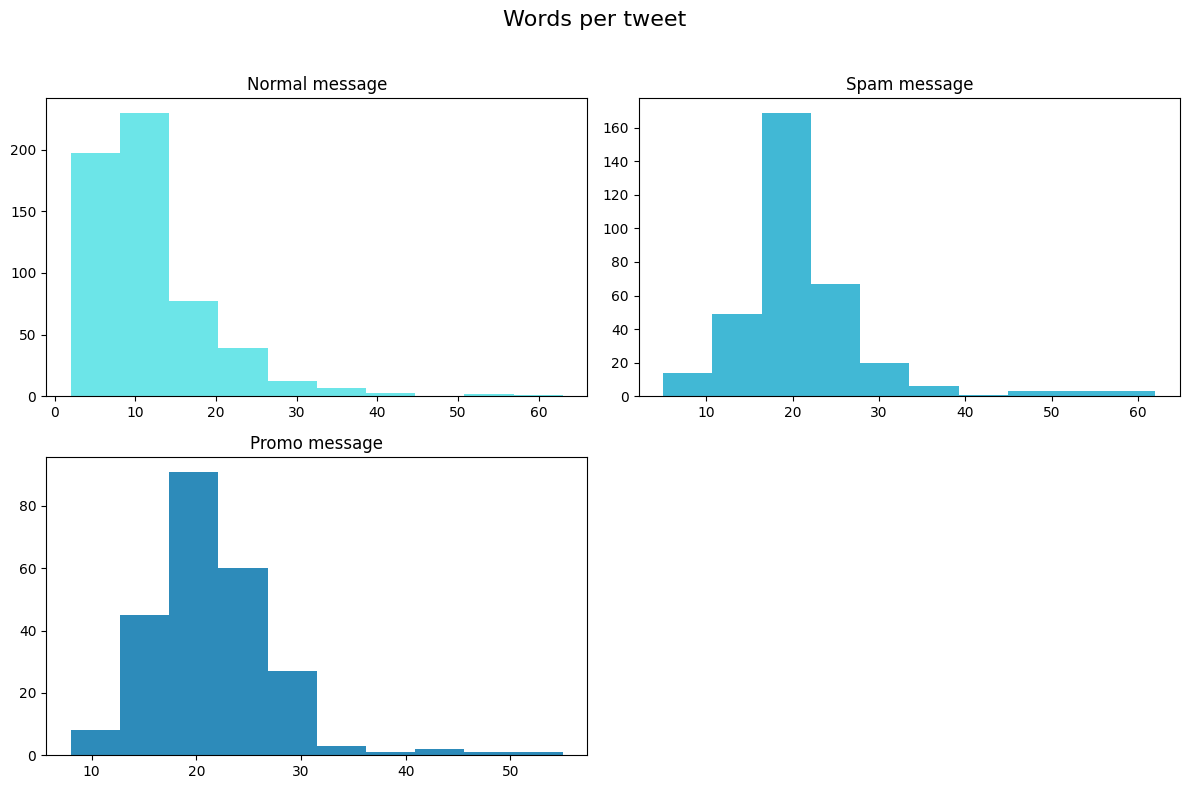

In [20]:
import matplotlib.pyplot as plt

# Memperbaiki warna dengan tanda kutip
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Normal message
train_words = df_eda[df_eda['label'] == 0]['word_count']
axes[0, 0].hist(train_words, color='#6ce5e8')
axes[0, 0].set_title('Normal message')

# Spam message
train_words = df_eda[df_eda['label'] == 1]['word_count']
axes[0, 1].hist(train_words, color='#41b8d5')
axes[0, 1].set_title('Spam message')

# Promo message
train_words = df_eda[df_eda['label'] == 2]['word_count']
axes[1, 0].hist(train_words, color='#2d8bba')
axes[1, 0].set_title('Promo message')

# Menghapus subplot kosong
axes[1, 1].axis('off')

# Menambahkan judul besar untuk semua subplot
fig.suptitle('Words per tweet', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

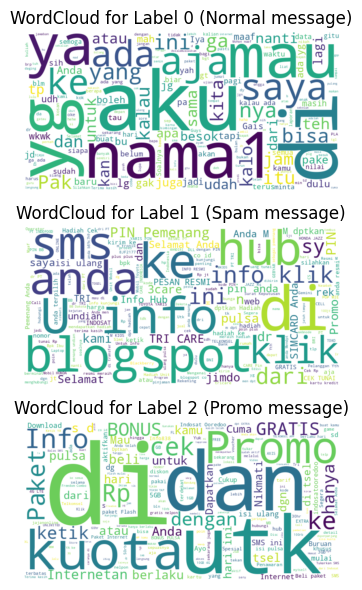

In [ ]:
from wordcloud import WordCloud

# Filter data berdasarkan label
label_0_text = ' '.join(df_eda[df_eda['label'] == 0]['Teks'])
label_1_text = ' '.join(df_eda[df_eda['label'] == 1]['Teks'])
label_2_text = ' '.join(df_eda[df_eda['label'] == 2]['Teks'])

# Membuat wordcloud untuk label 0 (misalnya 'Normal message')
wordcloud_0 = WordCloud(width=800, height=400, background_color='white').generate(label_0_text)

# Membuat wordcloud untuk label 1 (misalnya 'Spam message')
wordcloud_1 = WordCloud(width=800, height=400, background_color='white').generate(label_1_text)

# Membuat wordcloud untuk label 2 (misalnya 'Promo message')
wordcloud_2 = WordCloud(width=800, height=400, background_color='white').generate(label_2_text)

# Plotting hasil wordcloud untuk tiap label
fig, axes = plt.subplots(3, 1, figsize=(18, 6))

# Plot wordcloud untuk label 0
axes[0].imshow(wordcloud_0, interpolation='bilinear')
axes[0].set_title('WordCloud for Label 0 (Normal message)')
axes[0].axis('off')

# Plot wordcloud untuk label 1
axes[1].imshow(wordcloud_1, interpolation='bilinear')
axes[1].set_title('WordCloud for Label 1 (Spam message)')
axes[1].axis('off')

# Plot wordcloud untuk label 2
axes[2].imshow(wordcloud_2, interpolation='bilinear')
axes[2].set_title('WordCloud for Label 2 (Promo message)')
axes[2].axis('off')

plt.tight_layout()
plt.show()

- hub = hubungi
- sy = saya
- yg = yang
- utk = untuk
- tp = tapi
- udh = udah
- blm = belum
- jd = jadi
- lg = lagi
- dg = dengan
- sd = sampai dengan

# Data Preprocessing

In [ ]:
import nltk
# Ensure the stopwords package is downloaded
nltk.download('stopwords')
# Find the path of the stopwords resource
stopwords_path = nltk.data.find('corpora/stopwords.zip')
print(f"The stopwords resource is located at: {stopwords_path}")

The stopwords resource is located at: /root/nltk_data/corpora/stopwords.zip


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


##PREPROCESS 1

In [ ]:
def preprocess(text, slang_dict):
    # 1. Mengubah teks menjadi huruf kecil
    text = text.lower()

    # 2. Menghapus beberapa elemen
    text = text.strip()  # Menghapus spasi di awal/akhir teks
    text = re.compile('<.*?>').sub('', text)  # Menghapus tag HTML
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE) # Menghapus link
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  # Mengganti tanda baca dengan spasi
    text = re.sub('\s+', ' ', text)  # Menghapus spasi tambahan dan tab
    text = re.sub(r'\[[0-9]*\]', ' ', text)  # Menghapus angka dalam kurung siku
    text = re.sub(r'[^\w\s]', '', text)  # Menghapus karakter non-alfabet
    text = re.sub(r'\d', ' ', text)  # Menghapus angka
    text = re.sub(r'\s+', ' ', text)  # Menghapus spasi berlebih

    # 3. Menangani Kata Slang Bahasa Indonesia
    words = text.split()  # Split teks menjadi kata-kata
    processed_words = [slang_dict.get(word, word) for word in words]  # Ganti slang dengan kata asli
    text = ' '.join(processed_words)  # Gabungkan kembali menjadi satu teks

    return text

In [ ]:
# Kamus slang bahasa Indonesia
slang_dict_id = {
    "@": "di", "abis": "habis", "ad": "ada", "adlh": "adalah", "afaik": "as far as i know", "ahaha": "haha", "aj": "saja", "ajep-ajep": "dunia gemerlap", "ak": "saya", "akika": "aku", "akkoh": "aku", "akuwh": "aku", "alay": "norak", "alow": "halo", "ambilin": "ambilkan", "ancur": "hancur", "anjrit": "anjing", "anter": "antar", "ap2": "apa-apa", "apasih": "apa sih", "apes": "sial", "aps": "apa", "aq": "saya", "aquwh": "aku", "asbun": "asal bunyi", "aseekk": "asyik", "asekk": "asyik", "asem": "asam", "aspal": "asli tetapi palsu", "astul": "asal tulis", "ato": "atau", "au ah": "tidak mau tahu", "awak": "saya", "ay": "sayang", "ayank": "sayang", "b4": "sebelum", "bakalan": "akan", "bandes": "bantuan desa", "bangedh": "banget", "banpol": "bantuan polisi", "banpur": "bantuan tempur", "basbang": "basi", "bcanda": "bercanda", "bdg": "bandung", "begajulan": "nakal", "beliin": "belikan", "bencong": "banci", "bentar": "sebentar", "ber3": "bertiga", "beresin": "membereskan", "bete": "bosan", "beud": "banget", "bg": "abang", "bgmn": "bagaimana", "bgt": "banget", "bijimane": "bagaimana", "bintal": "bimbingan mental", "bkl": "akan", "bknnya": "bukannya", "blegug": "bodoh", "blh": "boleh", "bln": "bulan", "blum": "belum", "bnci": "benci", "bnran": "yang benar", "bodor": "lucu", "bokap": "ayah", "boker": "buang air besar", "bokis": "bohong", "boljug": "boleh juga", "bonek": "bocah nekat", "boyeh": "boleh", "br": "baru", "brg": "bareng", "bro": "saudara laki-laki", "bru": "baru", "bs": "bisa", "bsen": "bosan", "bt": "buat", "btw": "ngomong-ngomong", "buaya": "tidak setia", "bubbu": "tidur", "bubu": "tidur", "bumil": "ibu hamil", "bw": "bawa", "bwt": "buat", "byk": "banyak", "byrin": "bayarkan", "cabal": "sabar", "cadas": "keren", "calo": "makelar", "can": "belum", "capcus": "pergi", "caper": "cari perhatian", "ce": "cewek", "cekal": "cegah tangkal", "cemen": "penakut", "cengengesan": "tertawa", "cepet": "cepat", "cew": "cewek", "chuyunk": "sayang", "cimeng": "ganja", "cipika cipiki": "cium pipi kanan cium pipi kiri", "ciyh": "sih", "ckepp": "cakep", "ckp": "cakep", "cmiiw": "correct me if i'm wrong", "cmpur": "campur", "cong": "banci", "conlok": "cinta lokasi", "cowwyy": "maaf", "cp": "siapa", "cpe": "capek", "cppe": "capek", "cucok": "cocok", "cuex": "cuek", "cumi": "Cuma miscall", "cups": "culun", "curanmor": "pencurian kendaraan bermotor", "curcol": "curahan hati colongan", "cwek": "cewek", "cyin": "cinta", "d": "di", "dah": "deh", "dapet": "dapat", "de": "adik", "dek": "adik", "demen": "suka", "deyh": "deh", "dgn": "dengan", "diancurin": "dihancurkan", "dimaafin": "dimaafkan", "dimintak": "diminta", "disono": "di sana", "dket": "dekat", "dkk": "dan kawan-kawan", "dll": "dan lain-lain", "dlu": "dulu", "dngn": "dengan", "dodol": "bodoh", "doku": "uang", "dongs": "dong", "dpt": "dapat", "dri": "dari", "drmn": "darimana", "drtd": "dari tadi", "dst": "dan seterusnya", "dtg": "datang", "duh": "aduh", "duren": "durian", "ed": "edisi", "egp": "emang gue pikirin", "eke": "aku", "elu": "kamu", "emangnya": "memangnya", "emng": "memang", "endak": "tidak", "enggak": "tidak", "envy": "iri", "ex": "mantan", "fax": "facsimile", "fifo": "first in first out", "folbek": "follow back", "fyi": "sebagai informasi", "gaada": "tidak ada uang", "gag": "tidak", "gaje": "tidak jelas", "gak papa": "tidak apa-apa", "gan": "juragan", "gaptek": "gagap teknologi", "gatek": "gagap teknologi", "gawe": "kerja", "gbs": "tidak bisa", "gebetan": "orang yang disuka", "geje": "tidak jelas", "gepeng": "gelandangan dan pengemis", "ghiy": "lagi", "gile": "gila", "gimana": "bagaimana", "gino": "gigi nongol", "githu": "gitu", "gj": "tidak jelas", "gmana": "bagaimana", "gn": "begini", "goblok": "bodoh", "golput": "golongan putih", "gowes": "mengayuh sepeda", "gpny": "tidak punya", "gr": "gede rasa", "gretongan": "gratisan", "gtau": "tidak tahu", "gua": "saya", "guoblok": "goblok", "gw": "saya", "ha": "tertawa", "haha": "tertawa", "hallow": "halo", "hankam": "pertahanan dan keamanan", "hehe": "he", "helo": "halo", "hey": "hai", "hlm": "halaman", "hny": "hanya", "hoax": "isu bohong", "hr": "hari", "hrus": "harus", "hubdar": "perhubungan darat", "huff": "mengeluh", "hum": "rumah", "humz": "rumah", "ilang": "hilang", "ilfil": "tidak suka", "imho": "in my humble opinion", "imoetz": "imut", "item": "hitam", "itungan": "hitungan", "iye": "iya", "ja": "saja", "jadiin": "jadi", "jaim": "jaga image", "jayus": "tidak lucu", "jdi": "jadi", "jem": "jam", "jga": "juga", "jgnkan": "jangankan", "jir": "anjing", "jln": "jalan", "jomblo": "tidak punya pacar", "jubir": "juru bicara", "jutek": "galak", "k": "ke", "kab": "kabupaten", "kabor": "kabur", "kacrut": "kacau", "kadiv": "kepala divisi", "kagak": "tidak", "kalo": "kalau", "kampret": "sialan", "kamtibmas": "keamanan dan ketertiban masyarakat", "kamuwh": "kamu", "kanwil": "kantor wilayah", "karna": "karena", "kasubbag": "kepala subbagian", "katrok": "kampungan", "kayanya": "kayaknya", "kbr": "kabar", "kdu": "harus", "kec": "kecamatan", "kejurnas": "kejuaraan nasional", "kekeuh": "keras kepala", "kel": "kelurahan", "kemaren": "kemarin", "kepengen": "mau", "kepingin": "mau", "kepsek": "kepala sekolah", "kesbang": "kesatuan bangsa", "kesra": "kesejahteraan rakyat", "ketrima": "diterima", "kgiatan": "kegiatan", "kibul": "bohong", "kimpoi": "kawin", "kl": "kalau", "klianz": "kalian", "kloter": "kelompok terbang", "klw": "kalau", "km": "kamu", "kmps": "kampus", "kmrn": "kemarin", "knal": "kenal", "knp": "kenapa", "kodya": "kota madya", "komdis": "komisi disiplin", "komsov": "komunis sovyet", "kongkow": "kumpul bareng teman-teman", "kopdar": "kopi darat", "korup": "korupsi", "kpn": "kapan", "krenz": "keren", "krm": "kirim", "kt": "kita", "ktmu": "ketemu", "ktr": "kantor", "kuper": "kurang pergaulan", "kw": "imitasi", "kyk": "seperti", "la": "lah", "lam": "salam", "lamp": "lampiran", "lanud": "landasan udara", "latgab": "latihan gabungan", "lebay": "berlebihan", "leh": "boleh", "lelet": "lambat", "lemot": "lambat", "lgi": "lagi", "lgsg": "langsung", "liat": "lihat", "litbang": "penelitian dan pengembangan", "lmyn": "lumayan", "lo": "kamu", "loe": "kamu", "lola": "lambat berfikir", "louph": "cinta", "low": "kalau", "lp": "lupa", "luber": "langsung, umum, bebas, dan rahasia", "luchuw": "lucu", "lum": "belum", "luthu": "lucu", "lwn": "lawan", "maacih": "terima kasih", "mabal": "bolos", "macem": "macam", "macih": "masih", "maem": "makan", "magabut": "makan gaji buta", "maho": "homo", "mak jang": "kaget", "maksain": "memaksa", "malem": "malam", "mam": "makan", "maneh": "kamu", "maniez": "manis", "mao": "mau", "masukin": "masukkan", "melu": "ikut", "mepet": "dekat sekali", "mgu": "minggu", "migas": "minyak dan gas bumi", "mikol": "minuman beralkohol", "miras": "minuman keras", "mlah": "malah", "mngkn": "mungkin", "mo": "mau", "mokad": "mati", "moso": "masa", "mpe": "sampai", "msk": "masuk", "mslh": "masalah", "mt": "makan teman", "mubes": "musyawarah besar", "mulu": "melulu", "mumpung": "selagi", "munas": "musyawarah nasional", "muntaber": "muntah dan berak", "musti": "mesti", "muupz": "maaf", "mw": "now watching", "n": "dan", "nanam": "menanam", "nanya": "bertanya", "napa": "kenapa", "napi": "narapidana", "napza": "narkotika, alkohol, psikotropika, dan zat adiktif ", "narkoba": "narkotika, psikotropika, dan obat terlarang", "nasgor": "nasi goreng", "nda": "tidak", "ndiri": "sendiri", "ne": "ini", "nekolin": "neokolonialisme", "nembak": "menyatakan cinta", "ngabuburit": "menunggu berbuka puasa", "ngaku": "mengaku", "ngambil": "mengambil", "nganggur": "tidak punya pekerjaan", "ngapah": "kenapa", "ngaret": "terlambat", "ngasih": "memberikan", "ngebandel": "berbuat bandel", "ngegosip": "bergosip", "ngeklaim": "mengklaim", "ngeksis": "menjadi eksis", "ngeles": "berkilah", "ngelidur": "menggigau", "ngerampok": "merampok", "ngga": "tidak", "ngibul": "berbohong", "ngiler": "mau", "ngiri": "iri", "ngisiin": "mengisikan", "ngmng": "bicara", "ngomong": "bicara", "ngubek2": "mencari-cari", "ngurus": "mengurus", "nie": "ini", "nih": "ini", "niyh": "nih", "nmr": "nomor", "nntn": "nonton", "nobar": "nonton bareng", "np": "now playing", "ntar": "nanti", "ntn": "nonton", "numpuk": "bertumpuk", "nutupin": "menutupi", "nyari": "mencari", "nyekar": "menyekar", "nyicil": "mencicil", "nyoblos": "mencoblos", "nyokap": "ibu", "ogah": "tidak mau", "ol": "online", "ongkir": "ongkos kirim", "oot": "out of topic", "org2": "orang-orang", "ortu": "orang tua", "otda": "otonomi daerah", "otw": "on the way, sedang di jalan", "pacal": "pacar", "pake": "pakai", "pala": "kepala", "pansus": "panitia khusus", "parpol": "partai politik", "pasutri": "pasangan suami istri", "pd": "pada", "pede": "percaya diri", "pelatnas": "pemusatan latihan nasional", "pemda": "pemerintah daerah", "pemkot": "pemerintah kota", "pemred": "pemimpin redaksi", "penjas": "pendidikan jasmani", "perda": "peraturan daerah", "perhatiin": "perhatikan", "pesenan": "pesanan", "pgang": "pegang", "pi": "tapi", "pilkada": "pemilihan kepala daerah", "pisan": "sangat", "pk": "penjahat kelamin", "plg": "paling", "pmrnth": "pemerintah", "polantas": "polisi lalu lintas", "ponpes": "pondok pesantren", "pp": "pulang pergi", "prg": "pergi", "prnh": "pernah", "psen": "pesan", "pst": "pasti", "pswt": "pesawat", "pw": "posisi nyaman", "qmu": "kamu", "rakor": "rapat koordinasi", "ranmor": "kendaraan bermotor", "re": "reply", "ref": "referensi", "rehab": "rehabilitasi", "rempong": "sulit", "repp": "balas", "restik": "reserse narkotika", "rhs": "rahasia", "rmh": "rumah", "ru": "baru", "ruko": "rumah toko", "rusunawa": "rumah susun sewa", "ruz": "terus", "saia": "saya", "salting": "salah tingkah", "sampe": "sampai", "samsek": "sama sekali", "sapose": "siapa", "satpam": "satuan pengamanan", "sbb": "sebagai berikut", "sbh": "sebuah", "sbnrny": "sebenarnya", "scr": "secara", "sdgkn": "sedangkan", "sdkt": "sedikit", "se7": "setuju", "sebelas dua belas": "mirip", "sembako": "sembilan bahan pokok", "sempet": "sempat", "sendratari": "seni drama tari", "sgt": "sangat", "shg": "sehingga", "siech": "sih", "sikon": "situasi dan kondisi", "sinetron": "sinema elektronik", "siramin": "siramkan", "sj": "saja", "skalian": "sekalian", "sklh": "sekolah", "skt": "sakit", "slesai": "selesai", "sll": "selalu", "slma": "selama", "slsai": "selesai", "smpt": "sempat", "smw": "semua", "sndiri": "sendiri", "soljum": "sholat jumat", "songong": "sombong", "sory": "maaf", "sosek": "sosial-ekonomi", "sotoy": "sok tahu", "spa": "siapa", "sppa": "siapa", "spt": "seperti", "srtfkt": "sertifikat", "stiap": "setiap", "stlh": "setelah", "suk": "masuk", "sumpek": "sempit", "syg": "sayang", "t4": "tempat", "tajir": "kaya", "tau": "tahu", "taw": "tahu", "td": "tadi", "tdk": "tidak", "teh": "kakak perempuan", "telat": "terlambat", "telmi": "telat berpikir", "temen": "teman", "tengil": "menyebalkan", "tepar": "terkapar", "tggu": "tunggu", "tgu": "tunggu", "thankz": "terima kasih", "thn": "tahun", "tilang": "bukti pelanggaran", "tipiwan": "TvOne", "tks": "terima kasih", "tlp": "telepon", "tls": "tulis", "tmbah": "tambah", "tmen2": "teman-teman", "tmpah": "tumpah", "tmpt": "tempat", "tngu": "tunggu", "tnyta": "ternyata", "tokai": "tai", "toserba": "toko serba ada", "tpi": "tapi", "trdhulu": "terdahulu", "trima": "terima kasih", "trm": "terima", "trs": "terus", "trutama": "terutama", "ts": "penulis", "tst": "tahu sama tahu", "ttg": "tentang", "tuch": "tuh", "tuir": "tua", "tw": "tahu", "u": "kamu", "ud": "sudah", "udah": "sudah", "ujg": "ujung", "ul": "ulangan", "unyu": "lucu", "uplot": "unggah", "urang": "saya", "usah": "perlu", "utk": "untuk", "valas": "valuta asing", "w/": "dengan", "wadir": "wakil direktur", "wamil": "wajib militer", "warkop": "warung kopi", "warteg": "warung tegal", "wat": "buat", "wkt": "waktu", "wtf": "what the fuck", "xixixi": "tertawa", "ya": "iya", "yap": "iya", "yaudah": "ya sudah", "yawdah": "ya sudah", "yl": "yang lain", "yo": "iya", "yowes": "ya sudah", "yup": "iya", "7an": "tujuan", "ababil": "abg labil", "acc": "accord", "adlah": "adalah", "adoh": "aduh", "aha": "tertawa", "aing": "saya", "aja": "saja", "ajj": "saja", "aka": "dikenal juga sebagai", "akko": "aku", "akku": "aku", "akyu": "aku", "aljasa": "asal jadi saja", "ama": "sama", "ambl": "ambil", "anjir": "anjing", "ank": "anak", "ap": "apa", "apaan": "apa", "ape": "apa", "aplot": "unggah", "apva": "apa", "aqu": "aku", "asap": "sesegera mungkin", "aseek": "asyik", "asek": "asyik", "aseknya": "asyiknya", "asoy": "asyik", "astrojim": "astagfirullahaladzim", "ath": "kalau begitu", "atuh": "kalau begitu", "ava": "avatar", "aws": "awas", "ayang": "sayang", "ayok": "ayo", "bacot": "banyak bicara", "bales": "balas", "bangdes": "pembangunan desa", "bangkotan": "tua", "banpres": "bantuan presiden", "bansarkas": "bantuan sarana kesehatan", "bazis": "badan amal, zakat, infak, dan sedekah", "bcoz": "karena", "beb": "sayang", "bejibun": "banyak", "belom": "belum", "bener": "benar", "ber2": "berdua", "berdikari": "berdiri di atas kaki sendiri", "bet": "banget", "beti": "beda tipis", "beut": "banget", "bgd": "banget", "bgs": "bagus", "bhubu": "tidur", "bimbuluh": "bimbingan dan penyuluhan", "bisi": "kalau-kalau", "bkn": "bukan", "bl": "beli", "blg": "bilang", "blm": "belum", "bls": "balas", "bnchi": "benci", "bngung": "bingung", "bnyk": "banyak", "bohay": "badan aduhai", "bokep": "porno", "bokin": "pacar", "bole": "boleh", "bolot": "bodoh", "bonyok": "ayah ibu", "bpk": "bapak", "brb": "segera kembali", "brngkt": "berangkat", "brp": "berapa", "brur": "saudara laki-laki", "bsa": "bisa", "bsk": "besok", "bu_bu": "tidur", "bubarin": "bubarkan", "buber": "buka bersama", "bujubune": "luar biasa", "buser": "buru sergap", "bwhn": "bawahan", "byar": "bayar", "byr": "bayar", "c8": "chat", "cabut": "pergi", "caem": "cakep", "cama-cama": "sama-sama", "cangcut": "celana dalam", "cape": "capek", "caur": "jelek", "cekak": "tidak ada uang", "cekidot": "coba lihat", "cemplungin": "cemplungkan", "ceper": "pendek", "ceu": "kakak perempuan", "cewe": "cewek", "cibuk": "sibuk", "cin": "cinta", "ciye": "cie", "ckck": "ck", "clbk": "cinta lama bersemi kembali", "cmpr": "campur", "cnenk": "senang", "congor": "mulut", "cow": "cowok", "coz": "karena", "cpa": "siapa", "gokil": "gila", "gombal": "suka merayu", "gpl": "tidak pakai lama", "gpp": "tidak apa-apa", "gretong": "gratis", "gt": "begitu", "gtw": "tidak tahu", "gue": "saya", "guys": "teman-teman", "gws": "cepat sembuh", "haghaghag": "tertawa", "hakhak": "tertawa", "handak": "bahan peledak", "hansip": "pertahanan sipil", "hellow": "halo", "helow": "halo", "hi": "hai", "hlng": "hilang", "hnya": "hanya", "houm": "rumah", "hrs": "harus", "hubad": "hubungan angkatan darat", "hubla": "perhubungan laut", "huft": "mengeluh", "humas": "hubungan masyarakat", "idk": "saya tidak tahu", "ilfeel": "tidak suka", "imba": "jago sekali", "imoet": "imut", "info": "informasi", "itung": "hitung", "isengin": "bercanda", "iyala": "iya lah", "iyo": "iya", "jablay": "jarang dibelai", "jadul": "jaman dulu", "jancuk": "anjing", "jd": "jadi", "jdikan": "jadikan", "jg": "juga", "jgn": "jangan", "jijay": "jijik", "jkt": "jakarta", "jnj": "janji", "jth": "jatuh", "jurdil": "jujur adil", "jwb": "jawab", "ka": "kakak", "kabag": "kepala bagian", "kacian": "kasihan", "kadit": "kepala direktorat", "kaga": "tidak", "kaka": "kakak", "kamtib": "keamanan dan ketertiban", "kamuh": "kamu", "kamyu": "kamu", "kapt": "kapten", "kasat": "kepala satuan", "kasubbid": "kepala subbidang", "kau": "kamu", "kbar": "kabar", "kcian": "kasihan", "keburu": "terlanjur", "kedubes": "kedutaan besar", "kek": "seperti", "keknya": "kayaknya", "keliatan": "kelihatan", "keneh": "masih", "kepikiran": "terpikirkan", "kepo": "mau tahu urusan orang", "kere": "tidak punya uang", "kesian": "kasihan", "ketauan": "ketahuan", "keukeuh": "keras kepala", "khan": "kan", "kibus": "kaki busuk", "kk": "kakak", "klian": "kalian", "klo": "kalau", "kluarga": "keluarga", "klwrga": "keluarga", "kmari": "kemari", "kmpus": "kampus", "kn": "kan", "knl": "kenal", "knpa": "kenapa", "kog": "kok", "kompi": "komputer", "komtiong": "komunis Tiongkok", "konjen": "konsulat jenderal", "koq": "kok", "kpd": "kepada", "kptsan": "keputusan", "krik": "garing", "krn": "karena", "ktauan": "ketahuan", "ktny": "katanya", "kudu": "harus", "kuq": "kok", "ky": "seperti", "kykny": "kayanya", "laka": "kecelakaan", "lambreta": "lambat", "lansia": "lanjut usia", "lapas": "lembaga pemasyarakatan", "lbur": "libur", "lekong": "laki-laki", "lg": "lagi", "lgkp": "lengkap", "lht": "lihat", "linmas": "perlindungan masyarakat", "lmyan": "lumayan", "lngkp": "lengkap", "loch": "loh", "lol": "tertawa", "lom": "belum", "loupz": "cinta", "lowh": "kamu", "lu": "kamu", "luchu": "lucu", "luff": "cinta", "luph": "cinta", "lw": "kamu", "lwt": "lewat", "maaciw": "terima kasih", "mabes": "markas besar", "macem-macem": "macam-macam", "madesu": "masa depan suram", "maen": "main", "mahatma": "maju sehat bersama", "mak": "ibu", "makasih": "terima kasih", "malah": "bahkan", "malu2in": "memalukan", "mamz": "makan", "manies": "manis", "mantep": "mantap", "markus": "makelar kasus", "mba": "mbak", "mending": "lebih baik", "mgkn": "mungkin", "mhn": "mohon", "miker": "minuman keras", "milis": "mailing list", "mksd": "maksud", "mls": "malas", "mnt": "minta", "moge": "motor gede", "mokat": "mati", "mosok": "masa", "msh": "masih", "mskpn": "meskipun", "msng2": "masing-masing", "muahal": "mahal", "muker": "musyawarah kerja", "mumet": "pusing", "muna": "munafik", "munaslub": "musyawarah nasional luar biasa", "musda": "musyawarah daerah", "muup": "maaf", "muuv": "maaf", "nal": "kenal", "nangis": "menangis", "naon": "apa", "napol": "narapidana politik", "naq": "anak", "narsis": "bangga pada diri sendiri", "nax": "anak", "ndak": "tidak", "ndut": "gendut", "nekolim": "neokolonialisme", "nelfon": "menelepon", "ngabis2in": "menghabiskan", "ngakak": "tertawa", "ngambek": "marah", "ngampus": "pergi ke kampus", "ngantri": "mengantri", "ngapain": "sedang apa", "ngaruh": "berpengaruh", "ngawur": "berbicara sembarangan", "ngeceng": "kumpul bareng-bareng", "ngeh": "sadar", "ngekos": "tinggal di kos", "ngelamar": "melamar", "ngeliat": "melihat", "ngemeng": "bicara terus-terusan", "ngerti": "mengerti", "nggak": "tidak", "ngikut": "ikut", "nginep": "menginap", "ngisi": "mengisi", "ngmg": "bicara", "ngocol": "lucu", "ngomongin": "membicarakan", "ngumpul": "berkumpul", "ni": "ini", "nyasar": "tersesat", "nyariin": "mencari", "nyiapin": "mempersiapkan", "nyiram": "menyiram", "nyok": "ayo", "o/": "oleh", "ok": "ok", "priksa": "periksa", "pro": "profesional", "psn": "pesan", "psti": "pasti", "puanas": "panas", "qmo": "kamu", "qt": "kita", "rame": "ramai", "raskin": "rakyat miskin", "red": "redaksi", "reg": "register", "rejeki": "rezeki", "renstra": "rencana strategis", "reskrim": "reserse kriminal", "sni": "sini", "somse": "sombong sekali", "sorry": "maaf", "sosbud": "sosial-budaya", "sospol": "sosial-politik", "sowry": "maaf", "spd": "sepeda", "sprti": "seperti", "spy": "supaya", "stelah": "setelah", "subbag": "subbagian", "sumbangin": "sumbangkan", "syp": "siapa", "tabanas": "tabungan pembangunan nasional", "tar": "nanti", "taun": "tahun", "tawh": "tahu", "tdi": "tadi", "te2p": "tetap", "tekor": "rugi", "telkom": "telekomunikasi", "telp": "telepon", "temen2": "teman-teman", "tengok": "menjenguk", "terbitin": "terbitkan", "tgl": "tanggal", "thanks": "terima kasih", "thd": "terhadap", "thx": "terima kasih", "tipi": "TV", "tkg": "tukang", "tll": "terlalu", "tlpn": "telepon", "tman": "teman", "tmbh": "tambah", "tmn2": "teman-teman", "tmph": "tumpah", "tnda": "tanda", "tnh": "tanah", "togel": "toto gelap", "tp": "tapi", "tq": "terima kasih", "trgntg": "tergantung", "trims": "terima kasih", "cb": "coba", "y": "ya", "munfik": "munafik", "reklamuk": "reklamasi", "sma": "sama", "tren": "trend", "ngehe": "kesal", "mz": "mas", "analisise": "analisis", "sadaar": "sadar", "sept": "september", "nmenarik": "menarik", "zonk": "bodoh", "rights": "benar", "simiskin": "miskin", "ngumpet": "sembunyi", "hardcore": "keras", "akhirx": "akhirnya", "solve": "solusi", "watuk": "batuk", "ngebully": "intimidasi", "masy": "masyarakat", "still": "masih", "tauk": "tahu", "mbual": "bual", "tioghoa": "tionghoa", "ngentotin": "senggama", "kentot": "senggama", "faktakta": "fakta", "sohib": "teman", "rubahnn": "rubah", "trlalu": "terlalu", "nyela": "cela", "heters": "pembenci", "nyembah": "sembah", "most": "paling", "ikon": "lambang", "light": "terang", "pndukung": "pendukung", "setting": "atur", "seting": "akting", "next": "lanjut", "waspadalah": "waspada", "gantengsaya": "ganteng", "parte": "partai", "nyerang": "serang", "nipu": "tipu", "ktipu": "tipu", "jentelmen": "berani", "buangbuang": "buang", "tsangka": "tersangka", "kurng": "kurang", "ista": "nista", "less": "kurang", "koar": "teriak", "paranoid": "takut", "problem": "masalah", "tahi": "kotoran", "tirani": "tiran", "tilep": "tilap", "happy": "bahagia", "tak": "tidak", "penertiban": "tertib", "uasai": "kuasa", "mnolak": "tolak", "trending": "trend", "taik": "tahi", "wkwkkw": "tertawa", "ahokncc": "ahok", "istaa": "nista", "benarjujur": "jujur", "mgkin": "mungkin", "hub" : "hubungi", "sy" : "saya", "yg" : "yang", "utk" : "untuk", "udh" : "udah", "d" : "di", "dg" : "dengan", "sd" : "sampai dengan"
}

In [ ]:
# Contoh teks
sample_text = "woow, mgkin aku jd ikut, klo km?"

# Terapkan case folding
cleaned_text = preprocess(sample_text, slang_dict_id)
print(cleaned_text)

woow mungkin aku jadi ikut kalau kamu


In [ ]:
df_coba = df_train.copy()

In [ ]:
df_coba['clean_text'] = df_coba['Teks'].apply(lambda x: preprocess(x, slang_dict_id))
df_coba[['Teks', 'clean_text']].head()

,Teks,clean_text
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,promo beli paket flash mulai gb di my telkomse...
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,gb hari hanya rp ribu spesial buat anda yang t...
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",paling yth sisa kuota flash anda kb download m...
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",paling yth sisa kuota flash anda kb download m...
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,gb hari hanya rp ribu spesial buat anda yang t...


## Stemming - Lemmatization - Stopword

In [ ]:
pip install Sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 13.1 MB/s eta 0:00:00


In [ ]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.corpus import stopwords
import nltk

# Unduh stopwords NLTK
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# Inisialisasi stemmer dari Sastrawi
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Stopword Bahasa Indonesia
stop_words = set(stopwords.words('indonesian'))

# Fungsi untuk preprocessing gabungan
def preprocess_text(text):
    # Stemming & Lemmatization
    stemmed_text = stemmer.stem(text)

    # Tokenization
    tokens = stemmed_text.split()

    # Stopword Removal
    filtered_tokens = [word for word in tokens if word not in stop_words]

    # Gabungkan kembali ke teks
    processed_text = ' '.join(filtered_tokens)
    return processed_text

In [ ]:
def preprocess_final(text, slang_dict):
    # 1. normalisasi teks menggunakan preprocess 1
    normalized_text = preprocess(text, slang_dict)

    # 2. stemming, lemmatization, dan stopword removal
    final_text = preprocess_text(normalized_text)
    return final_text

In [ ]:
# ex function call
data = {
    'teks': [
        "Gue lg sibuk nih. Ada link-nya? Ntar aja ya!",
        "berlari dan bermain di taman sambil meminum air",
        "Jangan lupa buat janji dan tidak terlambat besok!"
    ]
}

# DataFrame
df_try = pd.DataFrame(data)

# Preprocess seluruh data
df_try['cleaned_teks'] = df_try['teks'].apply(lambda x: preprocess_final(x, slang_dict_id))
print(df_try)

                                                teks  \
0       Gue lg sibuk nih. Ada link-nya? Ntar aja ya!   
1    berlari dan bermain di taman sambil meminum air   
2  Jangan lupa buat janji dan tidak terlambat besok!   

                cleaned_teks  
0         sibuk link nya iya  
1  lari main taman minum air  
2    lupa janji lambat besok  


Try apply funct to df_try_2

In [ ]:
df_try_2 = df_train.copy()

In [ ]:
df_try_2['clean_text'] = df_try_2['Teks'].apply(lambda x: preprocess_final(x, slang_dict_id))
df_try_2[['Teks', 'clean_text']].head()

,Teks,clean_text
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,promo beli paket flash gb my telkomsel app ext...
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,gb rp ribu spesial pilih aktif promo nov buru ...
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",yth sisa kuota flash kb download mytelkomsel a...
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",yth sisa kuota flash kb download mytelkomsel a...
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,gb rp ribu spesial pilih aktif buru skb


In [ ]:
df_train.head()

,Teks,label
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,2
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,2
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",2
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",2
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,2


In [ ]:
df_train['clean_text'] = df_train['Teks'].apply(lambda x: preprocess_final(x, slang_dict_id))
df_train[['Teks', 'clean_text']].head()

,Teks,clean_text
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,promo beli paket flash gb my telkomsel app ext...
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,gb rp ribu spesial pilih aktif promo nov buru ...
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",yth sisa kuota flash kb download mytelkomsel a...
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",yth sisa kuota flash kb download mytelkomsel a...
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,gb rp ribu spesial pilih aktif buru skb


In [51]:
df_eda_preprocess = df_cleaned.copy()

In [53]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

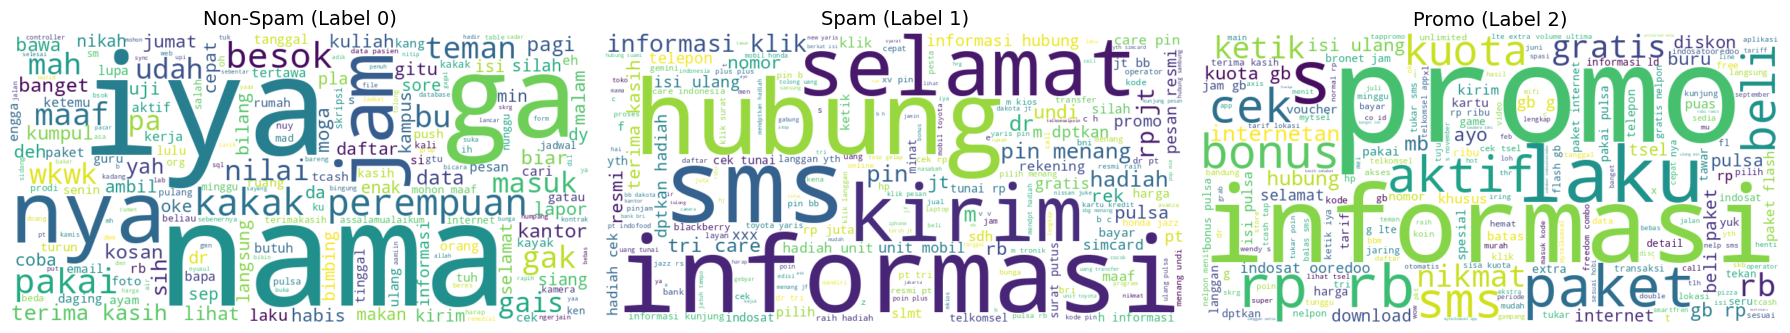

In [55]:
# Fungsi untuk membuat WordCloud berdasarkan label
def generate_wordcloud_by_label(df, label, title, ax):
    text = " ".join(df[df['label'] == label]['clean_text'].astype(str))
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap='viridis',
        max_words=200
    ).generate(text)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(title, fontsize=14)
    ax.axis('off')

# Plot WordCloud untuk setiap label
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

generate_wordcloud_by_label(df_eda_preprocess, 0, 'Non-Spam (Label 0)', axes[0])
generate_wordcloud_by_label(df_eda_preprocess, 1, 'Spam (Label 1)', axes[1])
generate_wordcloud_by_label(df_eda_preprocess, 2, 'Promo (Label 2)', axes[2])

plt.tight_layout()
plt.show()

In [ ]:
df_cleaned = df_train.copy()

# Modeling

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.metrics import classification_report
from gensim.models import Word2Vec

In [ ]:
# split data:
X = df_cleaned['clean_text']
y = df_cleaned['label']

# Train-Test Split
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [56]:
y_train.value_counts()

,count
label,
0,436
1,241
2,179


In [57]:
y_test.value_counts()

,count
label,
0,132
1,94
2,60


## TF-IDF

In [ ]:
### 1. TF-IDF ###
# TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=5000)  # Menentukan jumlah maksimum fitur
X_train_tfidf = tfidf.fit_transform(X_train_raw)
X_test_tfidf = tfidf.transform(X_test_raw)

# Logistic Regression with TF-IDF
lr_tfidf = LogisticRegression()
lr_tfidf.fit(X_train_tfidf, y_train)
y_pred_lr_tfidf = lr_tfidf.predict(X_test_tfidf)
print("Logistic Regression (TF-IDF):\n", classification_report(y_test, y_pred_lr_tfidf))

# Naive Bayes with TF-IDF
nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_train_tfidf, y_train)
y_pred_nb_tfidf = nb_tfidf.predict(X_test_tfidf)
print("Naive Bayes (TF-IDF):\n", classification_report(y_test, y_pred_nb_tfidf))

Logistic Regression (TF-IDF):
               precision    recall  f1-score   support

           0       0.88      0.95      0.92       132
           1       0.94      0.82      0.88        94
           2       0.84      0.85      0.84        60

    accuracy                           0.89       286
   macro avg       0.89      0.87      0.88       286
weighted avg       0.89      0.89      0.89       286

Naive Bayes (TF-IDF):
               precision    recall  f1-score   support

           0       0.97      0.91      0.94       132
           1       0.91      0.94      0.92        94
           2       0.86      0.93      0.90        60

    accuracy                           0.92       286
   macro avg       0.91      0.93      0.92       286
weighted avg       0.93      0.92      0.92       286



Logistic Regression (TF-IDF):
               precision    recall  f1-score   support

           0       0.88      0.95      0.92       132
           1       0.94      0.82      0.88        94
           2       0.84      0.85      0.84        60

    accuracy                           0.89       286
   macro avg       0.89      0.87      0.88       286
weighted avg       0.89      0.89      0.89       286



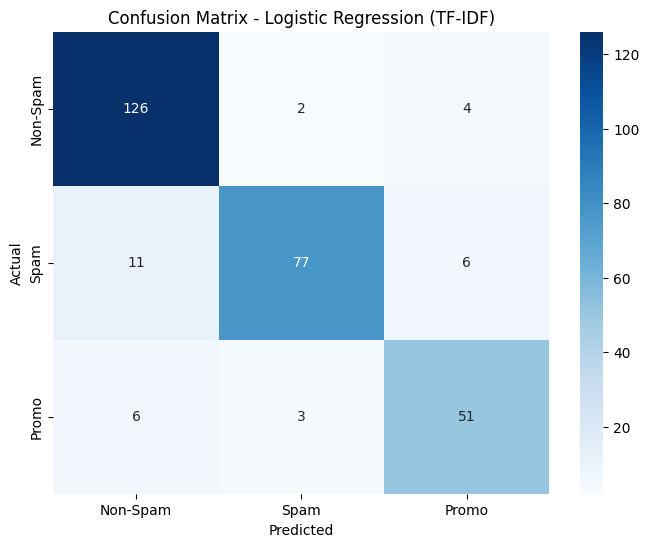

In [ ]:
# Classification Report
print("Logistic Regression (TF-IDF):\n", classification_report(y_test, y_pred_lr_tfidf))

# Confusion Matrix
cm_lr = confusion_matrix(y_test, y_pred_lr_tfidf)

# Plotting the confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Blues", xticklabels=['Non-Spam', 'Spam', 'Promo'], yticklabels=['Non-Spam', 'Spam', 'Promo'])
plt.title("Confusion Matrix - Logistic Regression (TF-IDF)")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Naive Bayes (TF-IDF):
               precision    recall  f1-score   support

           0       0.97      0.91      0.94       132
           1       0.91      0.94      0.92        94
           2       0.86      0.93      0.90        60

    accuracy                           0.92       286
   macro avg       0.91      0.93      0.92       286
weighted avg       0.93      0.92      0.92       286



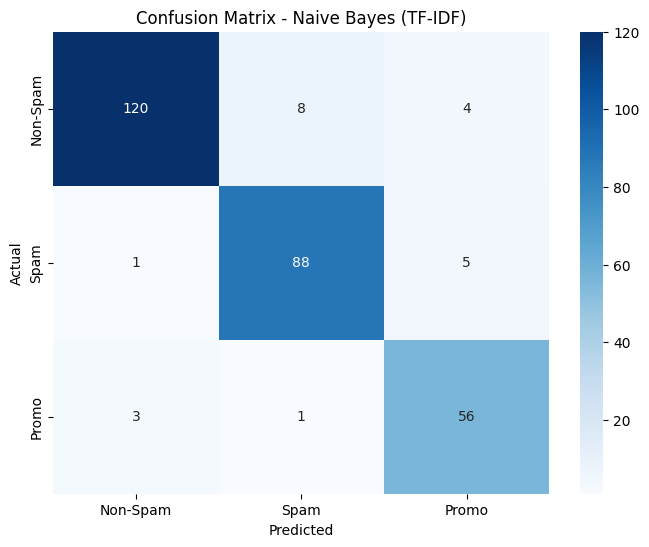

In [ ]:
# Classification Report
print("Naive Bayes (TF-IDF):\n", classification_report(y_test, y_pred_nb_tfidf))

# Confusion Matrix
cm_nb = confusion_matrix(y_test, y_pred_nb_tfidf)

# Plotting the confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm_nb, annot=True, fmt="d", cmap="Blues", xticklabels=['Non-Spam', 'Spam', 'Promo'], yticklabels=['Non-Spam', 'Spam', 'Promo'])
plt.title("Confusion Matrix - Naive Bayes (TF-IDF)")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Word2Vec

In [ ]:
### 2. Word2Vec ###
# Tokenisasi untuk Word2Vec
tokenized_corpus = X_train_raw.apply(lambda x: x.split()).tolist()

# Melatih Word2Vec Model
w2v_model = Word2Vec(sentences=tokenized_corpus, vector_size=100, window=5, min_count=1, workers=4)

# Representasi dokumen sebagai rata-rata vektor Word2Vec
def get_doc_vector(doc):
    words = doc.split()
    word_vectors = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(w2v_model.vector_size)

X_train_w2v = np.array([get_doc_vector(doc) for doc in X_train_raw])
X_test_w2v = np.array([get_doc_vector(doc) for doc in X_test_raw])

# Logistic Regression with Word2Vec
lr_w2v = LogisticRegression()
lr_w2v.fit(X_train_w2v, y_train)
y_pred_lr_w2v = lr_w2v.predict(X_test_w2v)
print("Logistic Regression (Word2Vec):\n", classification_report(y_test, y_pred_lr_w2v))

# Gaussian Naive Bayes with Word2Vec
gnb_w2v = GaussianNB()
gnb_w2v.fit(X_train_w2v, y_train)
y_pred_nb_w2v = gnb_w2v.predict(X_test_w2v)
print("Gaussian Naive Bayes (Word2Vec):\n", classification_report(y_test, y_pred_nb_w2v))

Logistic Regression (Word2Vec):
               precision    recall  f1-score   support

           0       0.46      0.99      0.63       132
           1       0.00      0.00      0.00        94
           2       0.00      0.00      0.00        60

    accuracy                           0.46       286
   macro avg       0.15      0.33      0.21       286
weighted avg       0.21      0.46      0.29       286

Gaussian Naive Bayes (Word2Vec):
               precision    recall  f1-score   support

           0       0.83      0.86      0.84       132
           1       0.83      0.64      0.72        94
           2       0.61      0.77      0.68        60

    accuracy                           0.77       286
   macro avg       0.75      0.76      0.75       286
weighted avg       0.78      0.77      0.77       286



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## FINAL MODEL

Final model yang akan saya gunakan adalah
### **Model Naive Bayes (TF-IDF)**
Karena secara keseluruhan model ini memiliki hasil evaluasi yang paling bagus dan performa paling baik.

# TESTING

In [ ]:
# data testing
df_new_test = {
    "text": [
        "Gratis pulsa Rp50.000 untuk pelanggan setia! Klik link ini untuk klaim sekarang.",
        "Rapat internal akan diadakan besok pukul 10:00 di ruang meeting lantai 2.",
        "Diskon besar-besaran hanya hari ini! Dapatkan produk favoritmu hingga 70% lebih murah.",
        "Hai, bagaimana kabarmu? Lama tak bertemu, kita perlu ngopi bareng!",
        "Selamat! Anda memenangkan undian senilai Rp1.000.000. Segera hubungi nomor ini.",
        "Promo spesial hari ibu! Dapatkan bunga segar hanya dengan separuh harga.",
        "Tolong kirimkan dokumen tersebut sebelum pukul 17:00 hari ini.",
        "Update keamanan: Jangan bagikan OTP kepada siapa pun untuk melindungi akun Anda."
    ],
    "expected_class": [
        1,  # spam
        0,  # non-spam
        2,  # promosi
        0,  # non-spam
        1,  # spam
        2,  # promosi
        0,  # non-spam
        0   # non-spam
    ]
}

df_new_test = pd.DataFrame(df_new_test)
df_new_test.head()

,text,expected_class
0,Gratis pulsa Rp50.000 untuk pelanggan setia! K...,1
1,Rapat internal akan diadakan besok pukul 10:00...,0
2,Diskon besar-besaran hanya hari ini! Dapatkan ...,2
3,"Hai, bagaimana kabarmu? Lama tak bertemu, kita...",0
4,Selamat! Anda memenangkan undian senilai Rp1.0...,1


In [ ]:
# Preprocessing data baru (sama seperti data training)
df_new_test['clean_text'] = df_new_test['text'].apply(lambda x: preprocess_final(x, slang_dict_id))
tfidf_new = tfidf.transform(df_new_test['clean_text'])  # Transformasikan dengan TF-IDF vectorizer yang sama

# Prediksi dengan model Naive Bayes
predictions = nb_tfidf.predict(tfidf_new)

# Menambahkan prediksi ke DataFrame
df_new_test['predicted_label'] = predictions

# Hasil
df_new_test[['text', 'predicted_label', 'expected_class']]

,text,predicted_label,expected_class
0,Gratis pulsa Rp50.000 untuk pelanggan setia! K...,1,1
1,Rapat internal akan diadakan besok pukul 10:00...,0,0
2,Diskon besar-besaran hanya hari ini! Dapatkan ...,2,2
3,"Hai, bagaimana kabarmu? Lama tak bertemu, kita...",0,0
4,Selamat! Anda memenangkan undian senilai Rp1.0...,1,1
5,Promo spesial hari ibu! Dapatkan bunga segar h...,2,2
6,Tolong kirimkan dokumen tersebut sebelum pukul...,0,0
7,Update keamanan: Jangan bagikan OTP kepada sia...,0,0


In [ ]:
probabilities = nb_tfidf.predict_proba(tfidf_new)
probabilities

array([[0.08325993, 0.50970257, 0.4070375 ],
       [0.83665159, 0.0867524 , 0.07659601],
       [0.28784886, 0.31098381, 0.40116734],
       [0.56245434, 0.23714033, 0.20040533],
       [0.04893173, 0.87395915, 0.07710912],
       [0.26535092, 0.34709538, 0.3875537 ],
       [0.48869596, 0.40650314, 0.10480091],
       [0.49399657, 0.24831595, 0.25768748]])

In [ ]:
# Hitung distribusi prediksi
class_distribution = pd.Series(predictions).value_counts()
class_distribution

,count
0,4
1,2
2,2


In [ ]:
# Prediksi probabilitas
probabilities = nb_tfidf.predict_proba(tfidf_new)

# Tambahkan probabilitas ke DataFrame
df_new_test['prob_class_0'] = probabilities[:, 0]  # Prob kelas 0
df_new_test['prob_class_1'] = probabilities[:, 1]  # Prob kelas 1
df_new_test['prob_class_2'] = probabilities[:, 2]  # Prob kelas 2

# Tampilkan hasil
df_new_test[['text', 'predicted_label', 'prob_class_0', 'prob_class_1', 'prob_class_2']]

,text,predicted_label,prob_class_0,prob_class_1,prob_class_2
0,Gratis pulsa Rp50.000 untuk pelanggan setia! K...,1,0.083260,0.509703,0.407038
1,Rapat internal akan diadakan besok pukul 10:00...,0,0.836652,0.086752,0.076596
2,Diskon besar-besaran hanya hari ini! Dapatkan ...,2,0.287849,0.310984,0.401167
3,"Hai, bagaimana kabarmu? Lama tak bertemu, kita...",0,0.562454,0.237140,0.200405
4,Selamat! Anda memenangkan undian senilai Rp1.0...,1,0.048932,0.873959,0.077109
5,Promo spesial hari ibu! Dapatkan bunga segar h...,2,0.265351,0.347095,0.387554
6,Tolong kirimkan dokumen tersebut sebelum pukul...,0,0.488696,0.406503,0.104801
7,Update keamanan: Jangan bagikan OTP kepada sia...,0,0.493997,0.248316,0.257687
